<a href="https://colab.research.google.com/github/eveapp/data_science/blob/Ketki/Topic%20Classification%20F20/Topic%20Modeling/Reddit_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this Notebook, we perform EDA on the preprocessed scraped data from previous two Notebooks. We try and detect trands in our data, what are some of the broad topics being discussed. We apply LDA (Latent Dirichlet Allocation) and NMF (Non-negative Matrix Factorization) algorithms to come up with 10 broad topics for our sentiment analysis project.



In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.6MB 3.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=63ead7234164d6825d3f8b1ca8a12320e97dd0df1df482ffcafabc967e41512e
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
import pandas as pd
import numpy as np
import nltk
import pickle
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

In [ ]:
with open('Reddit_dataset_clean.pkl', 'rb') as pickle_file:
  df_orig = pickle.load(pickle_file)
df_orig.head()

,title,score,id,url,comms_num,created,body,timestamp,lower,clean_body,clean_body_str,tokenized,pos_tags,wordnet_pos,lemmatized
0,I’m not ready.,616,9isza1,https://www.reddit.com/r/cancer/comments/9isza1/im_not_ready/,82,1.537917e+09,In 2016 I was diagnosed with stage 4 of a severely aggressive bone cancer after months of severe...,2018-09-25 23:13:21,"[in, 2016, i, was, diagnosed, with, stage, 4, of, a, severely, aggressive, bone, cancer, after, ...","[diagnosed, stage, severely, aggressive, bone, cancer, months, severe, pain, sacrum, left, leg, ...",diagnosed stage severely aggressive bone cancer months severe pain sacrum left leg diagnosed mon...,"[diagnosed, stage, severely, aggressive, bone, cancer, months, severe, pain, sacrum, left, leg, ...","[(diagnosed, VBN), (stage, NN), (severely, RB), (aggressive, JJ), (bone, NN), (cancer, NN), (mon...","[(diagnosed, v), (stage, n), (severely, r), (aggressive, a), (bone, n), (cancer, n), (months, n)...","[diagnose, stage, severely, aggressive, bone, cancer, month, severe, pain, sacrum, leave, leg, d..."
5,Onto Hospice. End of journey.,447,8y27xr,https://www.reddit.com/r/cancer/comments/8y27xr/onto_hospice_end_of_journey/,108,1.531363e+09,"The last treatment option, Immunotherapy, for my sarcoma cancer has failed. The scan showed that...",2018-07-12 02:41:20,"[the, last, treatment, option, immunotherapy, for, my, sarcoma, cancer, has, failed, the, scan, ...","[last, treatment, option, immunotherapy, sarcoma, cancer, failed, scan, showed, tumor, grown, si...",last treatment option immunotherapy sarcoma cancer failed scan showed tumor grown signed hospice...,"[last, treatment, option, immunotherapy, sarcoma, cancer, failed, scan, showed, tumor, grown, si...","[(last, JJ), (treatment, NN), (option, NN), (immunotherapy, NN), (sarcoma, NN), (cancer, NN), (f...","[(last, a), (treatment, n), (option, n), (immunotherapy, n), (sarcoma, n), (cancer, n), (failed,...","[last, treatment, option, immunotherapy, sarcoma, cancer, fail, scan, show, tumor, grown, sign, ..."
6,"Diagnosed in June, Dead in August",437,cuo28h,https://www.reddit.com/r/cancer/comments/cuo28h/diagnosed_in_june_dead_in_august/,49,1.566644e+09,My wonderful husband was diagnosed with cancer in June. In August we did 10 days of radiation. T...,2019-08-24 11:00:29,"[my, wonderful, husband, was, diagnosed, with, cancer, in, june, in, august, we, did, 10, days, ...","[wonderful, husband, diagnosed, cancer, june, august, days, radiation, monday, august, took, see...",wonderful husband diagnosed cancer june august days radiation monday august took see surgeon por...,"[wonderful, husband, diagnosed, cancer, june, august, days, radiation, monday, august, took, see...","[(wonderful, JJ), (husband, NN), (diagnosed, VBD), (cancer, NN), (june, NN), (august, VBP), (day...","[(wonderful, a), (husband, n), (diagnosed, v), (cancer, n), (june, n), (august, v), (days, n), (...","[wonderful, husband, diagnose, cancer, june, august, day, radiation, monday, august, take, see, ..."
7,Goodbye my sweet angel. I Lost my 5 year old daughter last night to complications from the treat...,441,e1o110,https://www.reddit.com/r/cancer/comments/e1o110/goodbye_my_sweet_angel_i_lost_my_5_year_old/,47,1.574750e+09,We had an incredible six months together after the diagnosis that I will cherish forever. We kne...,2019-11-26 06:31:46,"[we, had, an, incredible, six, months, together, after, the, diagnosis, that, i, will, cherish, ...","[incredible, six, months, together, diagnosis, cherish, forever, knew, start, likely, outcome, m...",incredible six months together diagnosis cherish forever knew start likely outcome make differen...,"[incredible, six, months, together, diagnosis, cherish, forever, knew, start, likely, outcome, m...","[(incredible, JJ), (six, CD), (months, NNS), (together, RB), (diagnosis, VBP), (cherish, JJ), (f...","[(incredible, a), (six, n), (months, n), (together, r), (diagnosis, v), (cherish, a), (forever, ...","[incredible, six, month, togethe

In [ ]:
# df_orig = pd.read_csv(''Reddit_dataset_clean.csv'')
# df_orig.head()

In [ ]:
#We only need the original body str  and lemmatized column 
df = df_orig[['body', 'lemmatized']]
df.head()

,body,lemmatized
0,In 2016 I was diagnosed with stage 4 of a severely aggressive bone cancer after months of severe...,"[diagnose, stage, severely, aggressive, bone, cancer, month, severe, pain, sacrum, leave, leg, d..."
5,"The last treatment option, Immunotherapy, for my sarcoma cancer has failed. The scan showed that...","[last, treatment, option, immunotherapy, sarcoma, cancer, fail, scan, show, tumor, grown, sign, ..."
6,My wonderful husband was diagnosed with cancer in June. In August we did 10 days of radiation. T...,"[wonderful, husband, diagnose, cancer, june, august, day, radiation, monday, august, take, see, ..."
7,We had an incredible six months together after the diagnosis that I will cherish forever. We kne...,"[incredible, six, month, together, diagnosis, cherish, forever, know, start, likely, outcome, ma..."
9,Just saw my doctor and he gave me results from the last round of test and I’m officially cancer ...,"[saw, doctor, give, result, last, round, test, I, officially, cancer, free, never, marry, kid, g..."


In [ ]:
#Add Lemma Str column
df['lemma_str'] = [' '.join(map(str,l)) for l in df['lemmatized']]
df.head()

,body,lemmatized,word_count,body_len,lemma_str
0,In 2016 I was diagnosed with stage 4 of a severely aggressive bone cancer after months of severe...,"[diagnose, stage, severely, aggressive, bone, cancer, month, severe, pain, sacrum, leave, leg, d...",592,6846,diagnose stage severely aggressive bone cancer month severe pain sacrum leave leg diagnose month...
5,"The last treatment option, Immunotherapy, for my sarcoma cancer has failed. The scan showed that...","[last, treatment, option, immunotherapy, sarcoma, cancer, fail, scan, show, tumor, grown, sign, ...",57,626,last treatment option immunotherapy sarcoma cancer fail scan show tumor grown sign hospice tell ...
6,My wonderful husband was diagnosed with cancer in June. In August we did 10 days of radiation. T...,"[wonderful, husband, diagnose, cancer, june, august, day, radiation, monday, august, take, see, ...",205,2306,wonderful husband diagnose cancer june august day radiation monday august take see surgeon port ...
7,We had an incredible six months together after the diagnosis that I will cherish forever. We kne...,"[incredible, six, month, together, diagnosis, cherish, forever, know, start, likely, outcome, ma...",85,1050,incredible six month together diagnosis cherish forever know start likely outcome make differenc...
9,Just saw my doctor and he gave me results from the last round of test and I’m officially cancer ...,"[saw, doctor, give, result, last, round, test, I, officially, cancer, free, never, marry, kid, g...",44,489,saw doctor give result last round test I officially cancer free never marry kid go cervical canc...


In [ ]:
#Count words in Lemmatized and Body Str
df['word_count'] = df['lemmatized'].apply(lambda x: len(str(x).split()))
df['body_len'] = df['body'].astype(str).apply(len)
df.head()

,body,lemmatized,word_count,body_len
0,In 2016 I was diagnosed with stage 4 of a severely aggressive bone cancer after months of severe...,"[diagnose, stage, severely, aggressive, bone, cancer, month, severe, pain, sacrum, leave, leg, d...",592,6846
5,"The last treatment option, Immunotherapy, for my sarcoma cancer has failed. The scan showed that...","[last, treatment, option, immunotherapy, sarcoma, cancer, fail, scan, show, tumor, grown, sign, ...",57,626
6,My wonderful husband was diagnosed with cancer in June. In August we did 10 days of radiation. T...,"[wonderful, husband, diagnose, cancer, june, august, day, radiation, monday, august, take, see, ...",205,2306
7,We had an incredible six months together after the diagnosis that I will cherish forever. We kne...,"[incredible, six, month, together, diagnosis, cherish, forever, know, start, likely, outcome, ma...",85,1050
9,Just saw my doctor and he gave me results from the last round of test and I’m officially cancer ...,"[saw, doctor, give, result, last, round, test, I, officially, cancer, free, never, marry, kid, g...",44,489


In [ ]:
words = df['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
print(allwords[1:1000])

['stage', 'severely', 'aggressive', 'bone', 'cancer', 'month', 'severe', 'pain', 'sacrum', 'leave', 'leg', 'diagnose', 'month', 'turn', 'ewing', '’', 's', 'sarcoma', 'rare', 'even', 'rarer', 'one', 'big', 'angry', 'tumour', 'sacrum', 'wrap', 'around', 'nerve', 'leg', 'name', 'shannon', 'aggressive', 'cancer', 'need', 'hit', 'even', 'aggressive', 'chemo', 'protocol', 'protocol', 'would', 'kill', 'adult', 'wasam', 'kid', 'severely', 'harm', 'bedridden', 'full', 'year', 'bit', 'treatment', 'radiation', 'fraction', 'round', 'chemo', 'induction', 'phase', 'round', 'every', 'three', 'week', 'year', 'suppose', 'every', 'week', 'hurt', 'body', 'threaten', 'blood', 'count', 'much', 'add', 'extra', 'week', 'recovery', 'time', 'horrible', 'year', 'life', 'friend', 'party', 'date', 'fun', 'sick', 'could', 'even', 'go', 'school', 'barely', 'conscious', 'friend', 'amaze', 'stuck', 'everything', 'anything', 'help', 'stress', 'family', 'bloody', 'amaze', 'I', 'never', 'go', 'able', 'repay', 'make', 'y

In [ ]:
mostcommon = FreqDist(allwords).most_common(1000)

In [ ]:
print(mostcommon)

[('I', 4475), ('cancer', 3115), ('go', 3051), ('get', 2793), ('know', 2405), ('time', 1915), ('feel', 1814), ('want', 1769), ('year', 1692), ('like', 1691), ('day', 1441), ('say', 1433), ('would', 1391), ('mom', 1301), ('make', 1299), ('take', 1253), ('one', 1244), ('month', 1212), ('chemo', 1147), ('tell', 1138), ('week', 1136), ('life', 1115), ('much', 1114), ('dad', 1104), ('think', 1101), ('help', 1100), ('could', 1045), ('see', 1000), ('last', 999), ('even', 991), ('thing', 956), ('really', 939), ('back', 928), ('treatment', 916), ('need', 895), ('love', 887), ('try', 887), ('come', 878), ('family', 864), ('start', 830), ('good', 830), ('work', 826), ('doctor', 804), ('still', 775), ('give', 775), ('find', 774), ('pain', 764), ('diagnose', 725), ('well', 719), ('u', 718), ('live', 709), ('stage', 703), ('ago', 702), ('never', 671), ('care', 654), ('people', 653), ('hospital', 647), ('bad', 641), ('also', 617), ('look', 612), ('talk', 607), ('home', 602), ('right', 601), ('die', 59

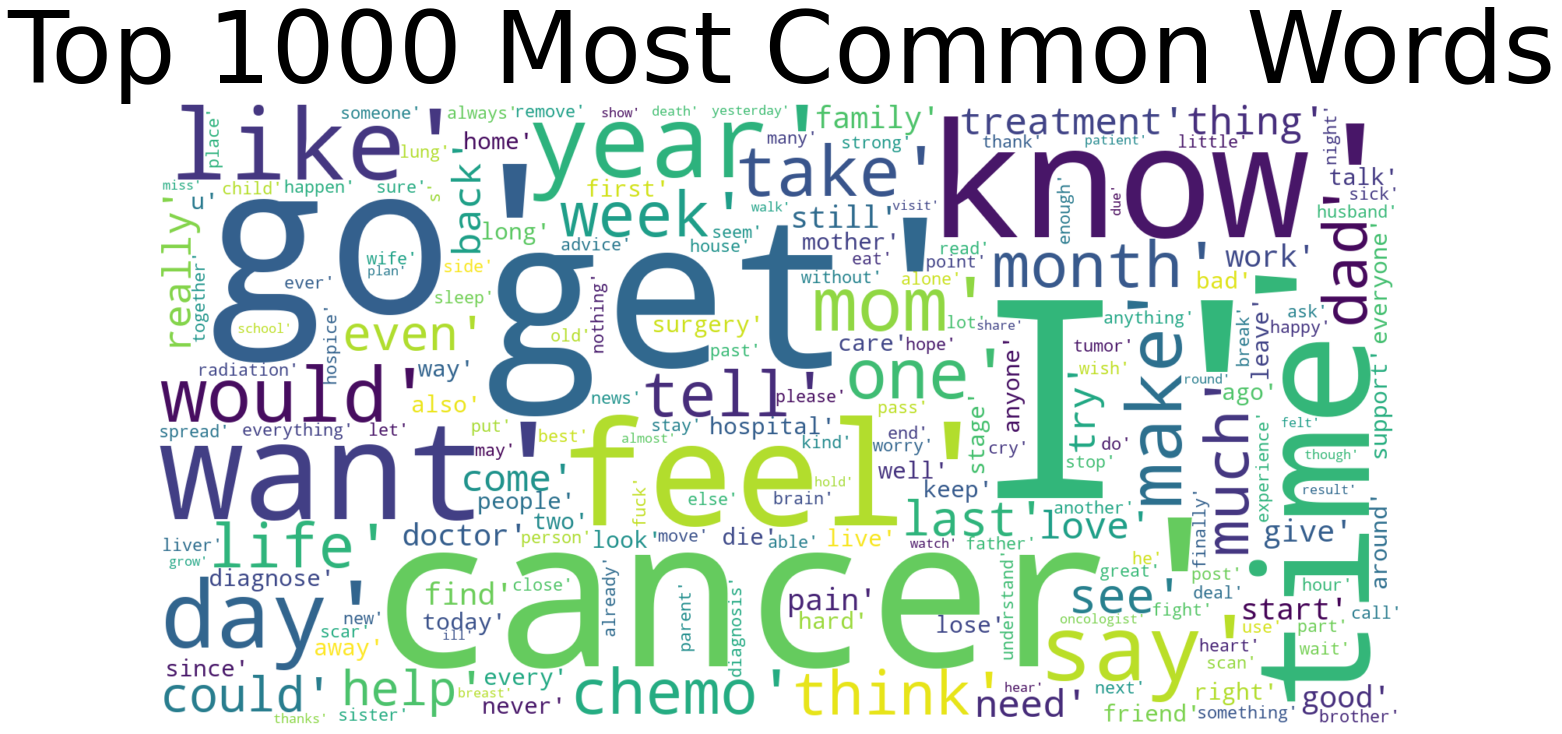

In [ ]:
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 1000 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()


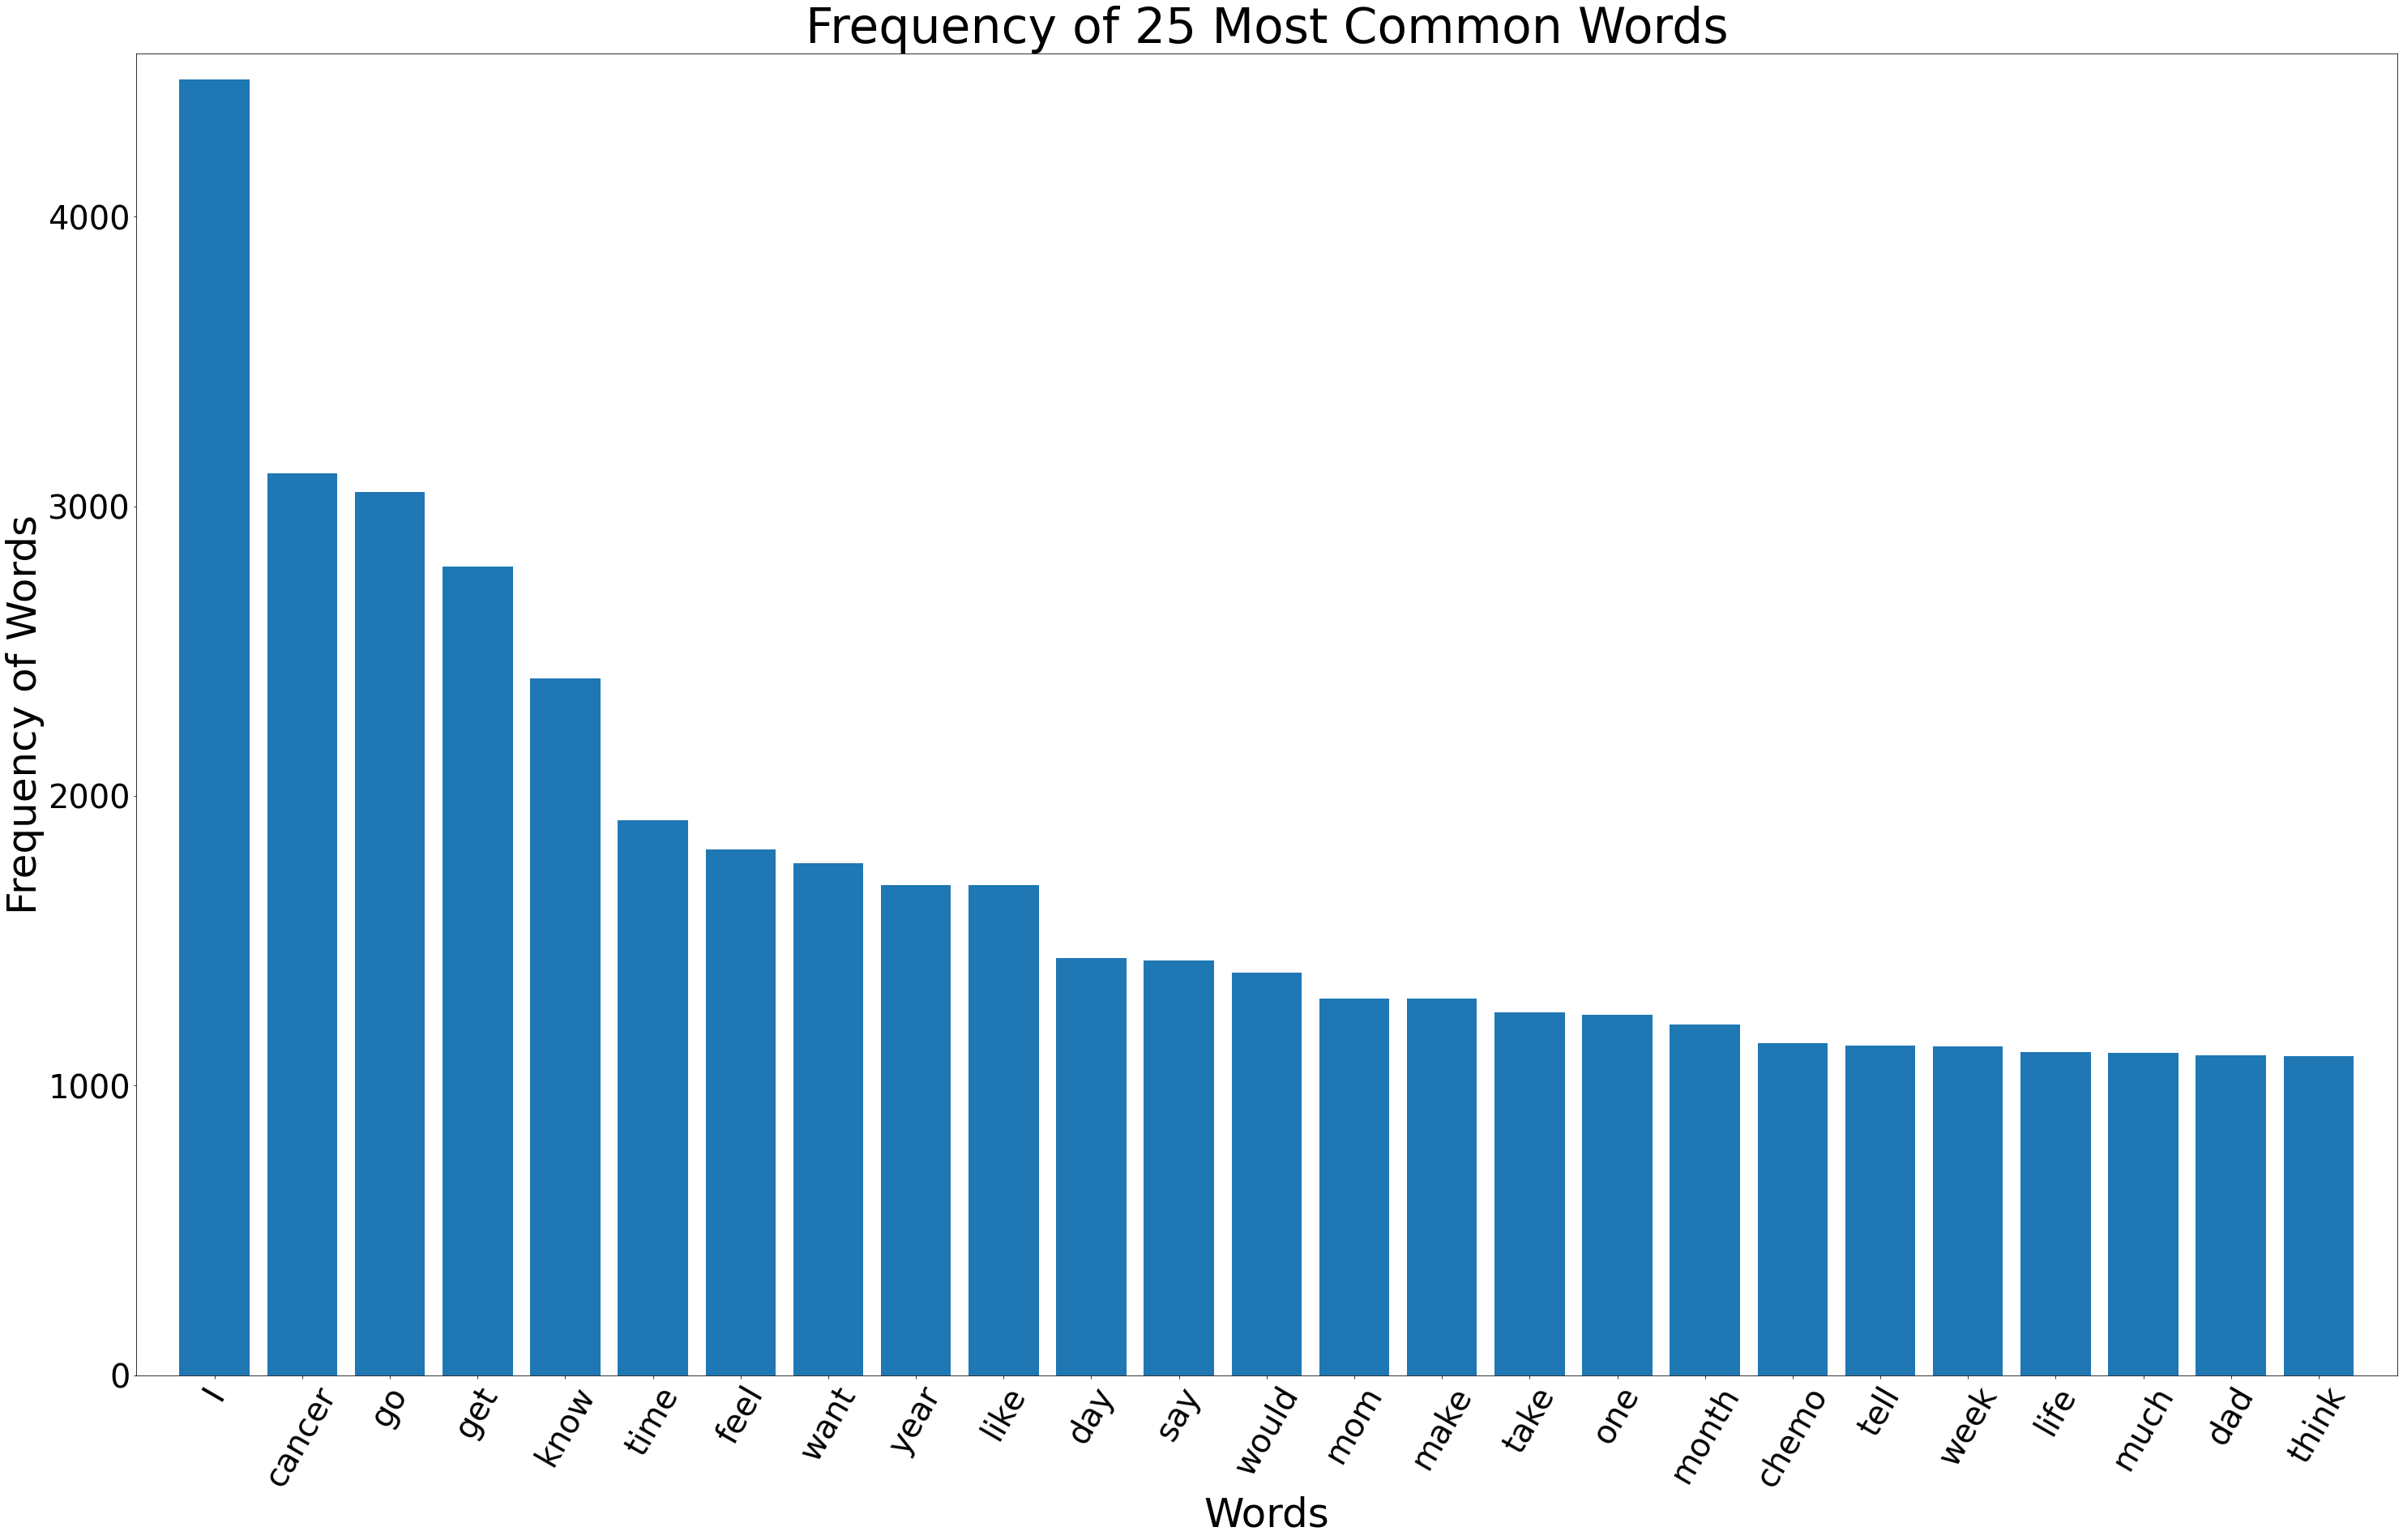

In [ ]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

In [ ]:
#Count vectorizer
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df['lemma_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

,abdomen,able,absolute,absolutely,accept,across,act,active,activity,actual,actually,add,admit,adult,advance,advice,affect,afford,afraid,age,aggressive,ago,agree,ahead,alive,allow,almost,alone,along,already,also,although,always,amaze,amazing,amount,anger,angry,another,answer,...,wed,wednesday,week,weekend,weight,weird,welcome,well,whatever,whenever,whether,whole,wife,willing,wish,within,without,woman,wonder,wonderful,word,work,world,worried,worry,worse,worth,would,write,wrong,xb,yeah,year,yell,yes,yesterday,yet,yo,you,young
0,0,2,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,2,2,0,0,0,1,1,0,...,0,0,4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,3,0,2,0,0,8,0,0,0,0,12,0,0,0,0,0,1,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2304,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2306,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Applying LDA to our corpus to see what topics come up

In [ ]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
node lymph xb pet lymphoma scan neck prayer show hodgkin
Topic 1:
year love know time life would cancer one go much
Topic 2:
pain take eat chemo stop sleep say even start day
Topic 3:
go get day say mom home could see week hospital
Topic 4:
cancer get year chemo go month treatment week surgery back
Topic 5:
want feel go like know think get try time really
Topic 6:
fuck get suck cancer husband bear shit god like run
Topic 7:
cancer support thank help people patient please post share one
Topic 8:
he get chemo round currently stage try hour cancer watch
Topic 9:
work take wife pill need would not blood doctor can


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,abdomen,able,absolute,absolutely,accept,across,act,active,activity,actual,actually,add,admit,adult,advance,advice,affect,afford,afraid,age,aggressive,ago,agree,ahead,alive,allow,almost,alone,along,already,also,although,always,amaze,amazing,amount,anger,angry,another,answer,...,wed,wednesday,week,weekend,weight,weird,welcome,well,whatever,whenever,whether,whole,wife,willing,wish,within,without,woman,wonder,wonderful,word,work,world,worried,worry,worse,worth,would,write,wrong,xb,yeah,year,yell,yes,yesterday,yet,yo,you,young
0,0.0,0.049594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033555,0.043672,0.037690,0.041784,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.103602,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.022169,0.0,0.050159,0.075850,0.0,0.0,0.0,0.034534,0.028589,0.0,...,0.0,0.000000,0.073812,0.000000,0.0,0.0,0.0,0.020695,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.026685,0.0,0.000000,0.000000,0.0,0.021060,0.09315,0.0,0.059103,0.0,0.0,0.142477,0.0,0.0,0.0,0.0,0.188566,0.0,0.0,0.000000,0.0,0.0,0.043911,0.093793
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.097958,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.136545,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.143314,0.0,0.000000,0.0,0.127452,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.085061,0.0,0.0,0.0,0.0,0.150102,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.043955,0.0,0.000000,0.075194,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.086588,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.076935,0.0,0.041756,0.00000,0.0,0.000000,0.0,0.0,0.035311,0.0,0.0,0.0,0.0,0.031156,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.162383,0.0,0.000000,0.0,0.212021,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.078000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.132383,0.000000,0.0,0.232895,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,0.0,0.130141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,0.0,0.099160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.114483,0.0,0.0,0.000000,0.138742,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.071219,0.0,0.0,0.0,0.0,0.062838,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2304,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.225664,0.000000,0.0,0.000000,0.0,0.0,0.233128,0.000000,0.000000,0.0614

In [ ]:
#Applying another Topic Modeling Algorithm called Non-Negative Matrix Factorization (NMF)
#This one produces more coherent topics
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)



Topic 0:
year old month ago cancer life week two diagnose last
Topic 1:
chemo scan surgery tumor cancer radiation treatment month round get
Topic 2:
support help cancer please thank patient people caregiver post treatment
Topic 3:
fuck cancer shit go god hate die suck kill xb
Topic 4:
dad cancer he stage brother mum die diagnose father live
Topic 5:
feel like really need alone thing life know even guilty
Topic 6:
mom sister stage cancer lose breast take care know help
Topic 7:
know want tell say go think would talk make people
Topic 8:
love pass miss much away pain last morning one peace
Topic 9:
day get take hospital go pain home work week time


**LDA topics: **

Topic 0:
node lymph xb pet lymphoma scan neck prayer show hodgkin

Topic 1:
year love know time life would cancer one go much

Topic 2:
pain take eat chemo stop sleep say even start day

Topic 3:
go get day say mom home could see week hospital

Topic 4:
cancer get year chemo go month treatment week surgery back

Topic 5:
want feel go like know think get try time really

Topic 6:
fuck get suck cancer husband bear shit god like run

Topic 7:
cancer support thank help people patient please post share one

Topic 8:
he get chemo round currently stage try hour cancer watch

Topic 9:
work take wife pill need would not blood doctor can

**Interpreted Topics**

Topic 0: Newly discovered

Topic 1: Chemo Treatement Experience

Topic 2: Post treatment Care

Topic 3: Expressing Frustration/ Hopelessness

Topic 4: Surgery

Topic 5: Guilt and loneliness

Topic 6: Losing battle/ Treatment ineffective

Topic 7: Want to reach out

Topic 8: Passing away

Topic 9: Remission
